# Task 1
## Loading and visualizing the image

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage

Let's create some constants for the file paths first

In [2]:
FILE_DIRECTORY = '.'
FILENAME_COINS = os.path.join(FILE_DIRECTORY, 'coins.jpg')
FILENAME_ASTRONAUT = os.path.join(FILE_DIRECTORY, 'astronaut.jpg')

Now let's define a function that prints the shape, data type and the intensity of an arbitrary pixel of a loaded image.

In [3]:
def first_look_at_image(image, filename):
    print(f"The shape of the {filename} image is: {image.shape}.")
    print(f"The type of the {filename} image is: {image.dtype}.")
    print(
        f"The intensity level of a random pixel in the {filename} image is: "
        f"{image[1, 100]}.")

Once the image is loaded, we can visualize it with either scikit-image or matplotlib

In [4]:
def visualize_image(image, show='skimage'):
    if show == 'skimage':
        skimage.io.imshow(image)
        skimage.io.show()
    elif show == 'plt':
        plt.imshow(image)

Finally we can create a pipeline of
- loading the image from a file
- having a first look at the size and type
- then visualizing it.

The shape of the ./coins.jpg image is: (303, 384).
The type of the ./coins.jpg image is: uint8.
The intensity level of a random pixel in the ./coins.jpg image is: 133.


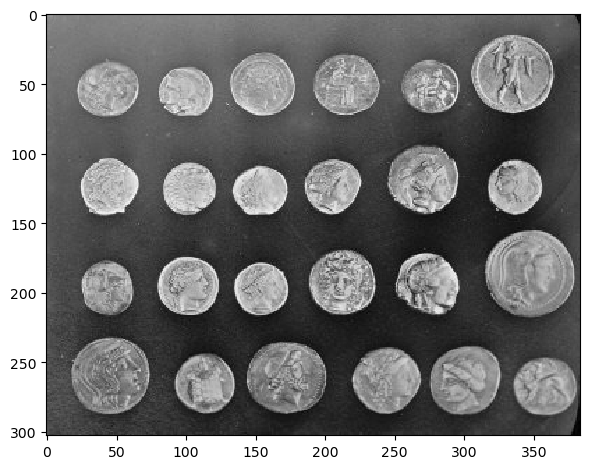

The shape of the ./astronaut.jpg image is: (512, 512, 3).
The type of the ./astronaut.jpg image is: uint8.
The intensity level of a random pixel in the ./astronaut.jpg image is: [178 174 175].


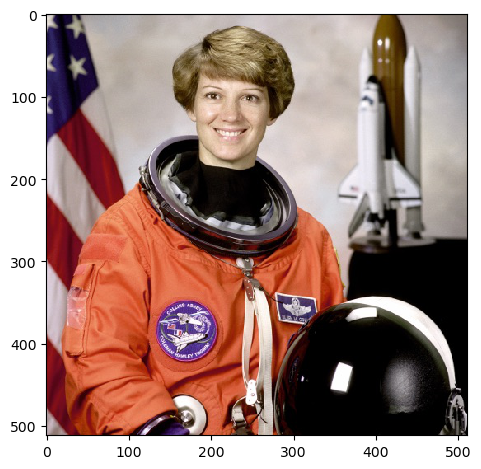

In [5]:
def run_task1_pipeline(filename):
    image = skimage.io.imread(filename)
    first_look_at_image(image, filename)
    visualize_image(image)
    return image, len(image.shape)


image_coins, dimension_coins = run_task1_pipeline(FILENAME_COINS)
image_astronaut, dimension_astronaut = run_task1_pipeline(FILENAME_ASTRONAUT)

We can observe that the coins image is already grayscale as the shape of the loaded image is 2-dimensional.

The astronaut image is 3-dimensional where the 3rd dimension is the 3 RGB color component.

Both images have an integer data type.

# Task 2
## Color space conversion

Let's create a function that
- converts the image from RGB to grayscale
- then prints the same attributes as before,
- and visualizes the image.

As the coins image was already grayscale, there is no need to run this conversion on it, as it will result in an exception.

The shape of the ./astronaut.jpg image is: (512, 512).
The type of the ./astronaut.jpg image is: float64.
The intensity level of a random pixel in the ./astronaut.jpg image is: 0.6859690196078432.


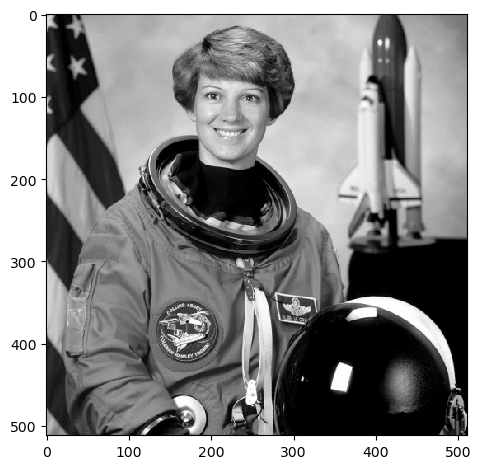

In [6]:
def run_task2_pipeline(image, filename):
    grayscale_image = skimage.color.rgb2gray(image)
    first_look_at_image(grayscale_image, filename)
    visualize_image(grayscale_image)
    return grayscale_image


image_astronaut_grayscale = run_task2_pipeline(image_astronaut, FILENAME_ASTRONAUT)
# run_task2_pipeline(image_coins, FILENAME_COINS)

`dtype` changes from integer to floating-point during the grayscale conversion,
while `size` goes from 3-dimensional array (the third dimension being the RGB values) to 2-dimensional array.

# Task 3
## Rescaling and resizing

Let's rescale the images by half, and resize them by factors of 0.25, 0.5 and 0.75, and then compare the results.

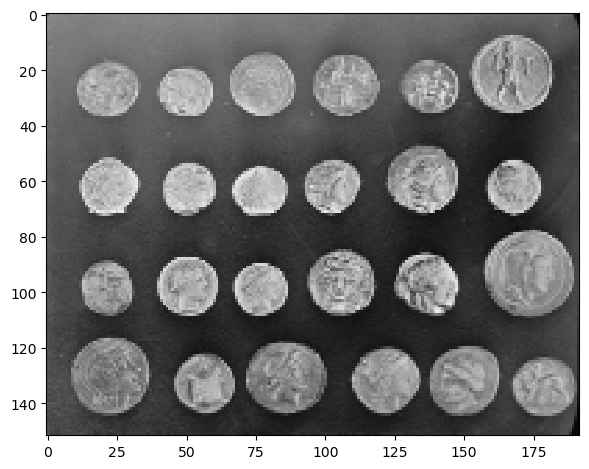

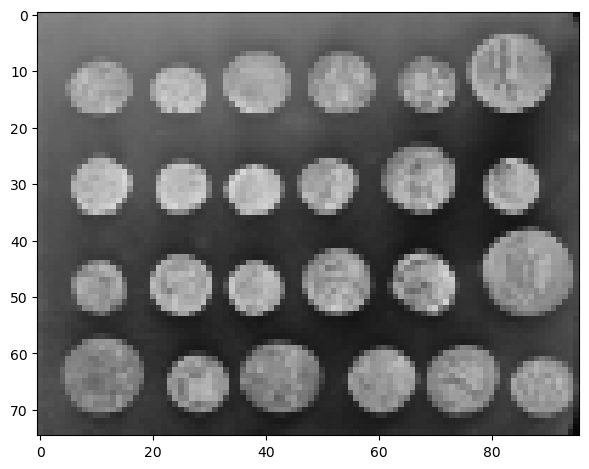

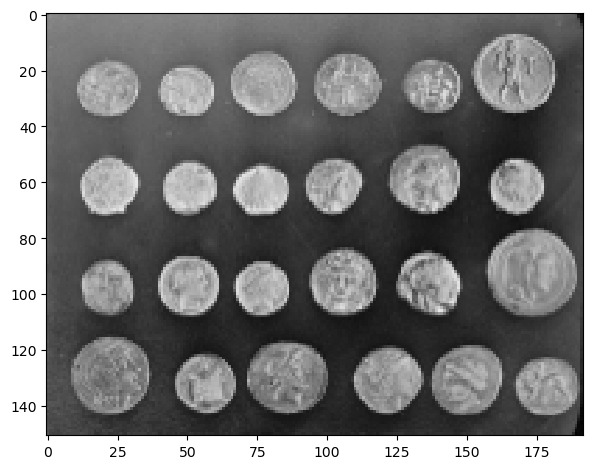

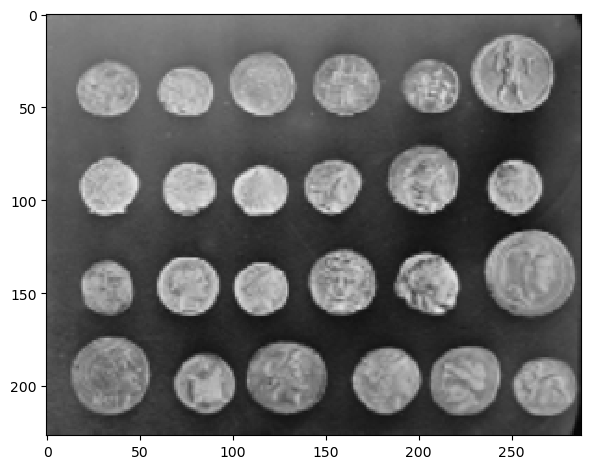

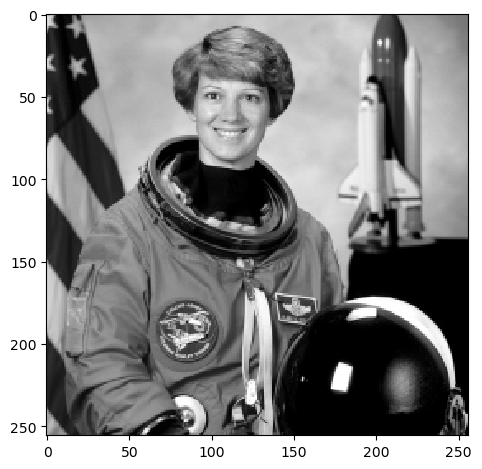

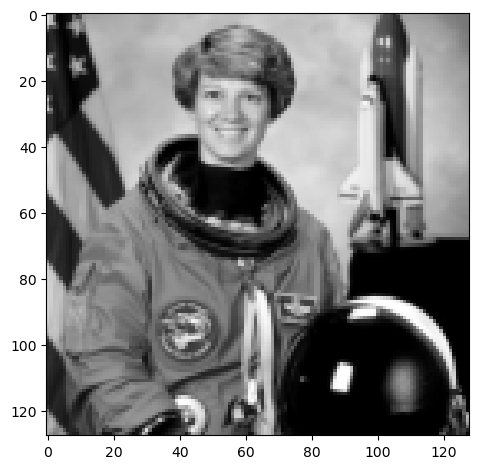

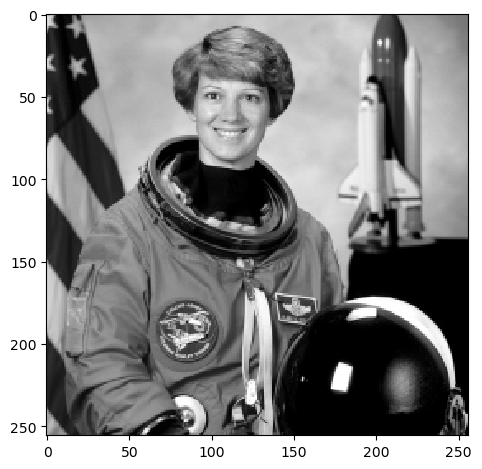

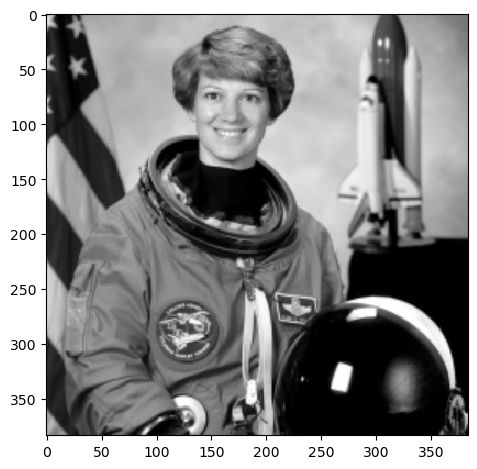

In [7]:
IMAGE_RESIZE_FACTORS_QUARTERS = [1, 2, 3]


def run_task3_pipeline(image):
    image_rescaled = skimage.transform.rescale(image, 0.5, anti_aliasing=False)
    skimage.io.imshow(image_rescaled)
    skimage.io.show()

    for factor in IMAGE_RESIZE_FACTORS_QUARTERS:
        image_resized = skimage.transform.resize(
            image_rescaled,
            tuple(coord * factor // 4 for coord in image.shape[:2]),
            anti_aliasing=True,
        )
        skimage.io.imshow(image_resized)
        skimage.io.show()

run_task3_pipeline(image_coins)
run_task3_pipeline(image_astronaut_grayscale)

As can be seen in the images above, the scaling will affect the resolution of the image. __Rescale__ operation resizes an image by a given scaling factor. The scaling factor can either be a single floating point value, or multiple values - one along each axis. The __Resize__ operation does the same thing but instead of providing a scaling factor we can supply the dimension of the output image instead.

We also see the effect of using anti aliasing (for resize) and not (for rescale).

# Task 4
## Thresholding

Let's create a function that plots the histogram and the thresholded image.

Start with only the histogram to find some reasonable values for the threshold.

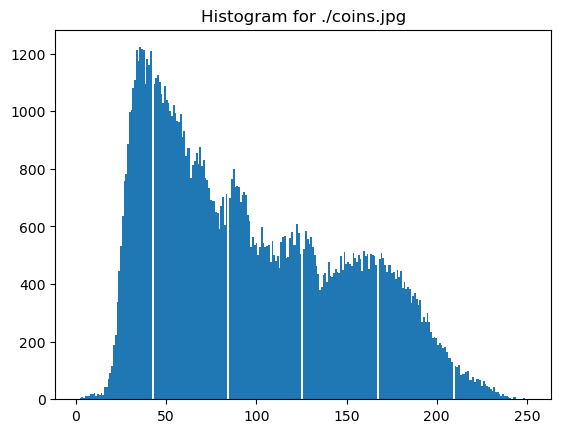

Text(0.5, 1.0, 'Histogram for ./astronaut.jpg')

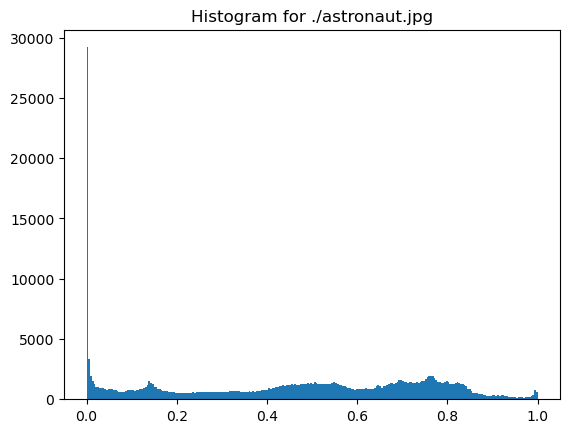

In [8]:
def run_task4_pipeline(image, filename, threshold):
    from skimage.exposure import histogram
    from skimage.util import img_as_ubyte

    ax = plt.hist(image.ravel(), bins=256)
    plt.title(f'Histogram for {filename}')

    fig, ax = plt.subplots()
    plt.imshow(image > threshold, cmap='gray')
    plt.show()


ax = plt.hist(image_coins.ravel(), bins=256)
plt.title(f'Histogram for {FILENAME_COINS}')
plt.show()

ax = plt.hist(image_astronaut_grayscale.ravel(), bins=256)
plt.title(f'Histogram for {FILENAME_ASTRONAUT}')

We can see that for the coins image a threshold of 120 seems to cut the distribution in half (as the values are integer on a scale of 0 to 255), while the astronaut image has floating-point values, so a reasonable threshold there would be around 0.4 or 0.5. The distribution is very skewed with a lot more dark than bright pixels.

Let's go with 120 and 0.4, respectively, and visualize the processed grayscale images:

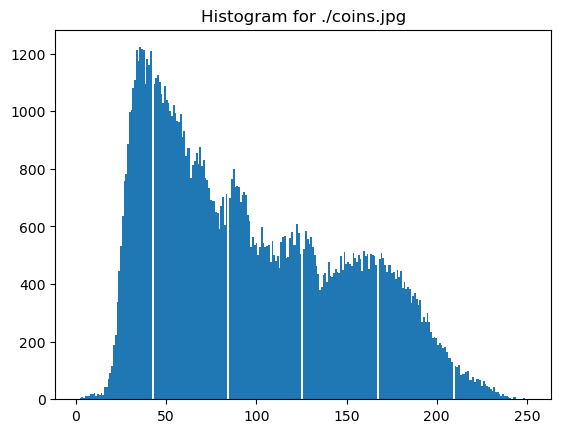

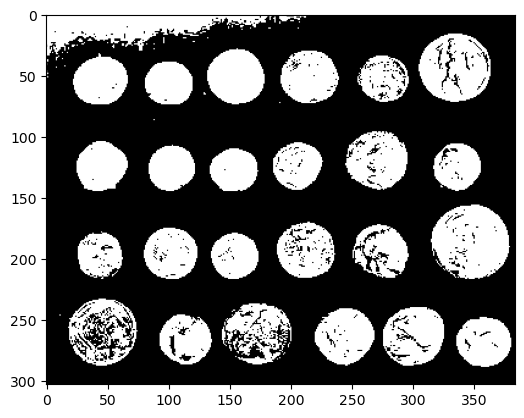

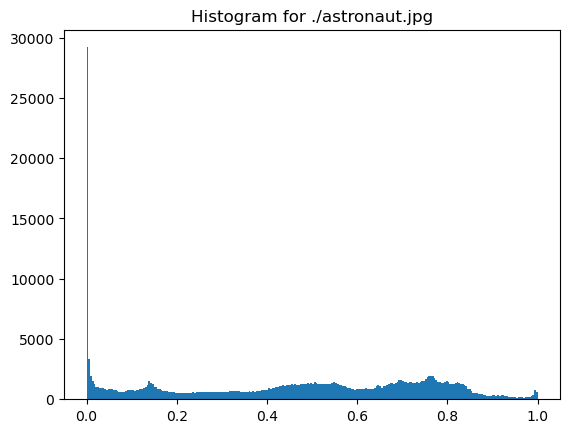

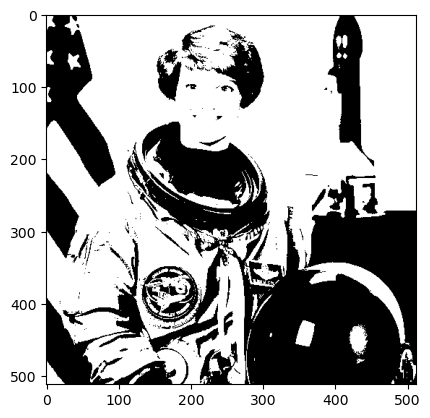

In [17]:
run_task4_pipeline(image_coins, FILENAME_COINS, threshold=120)
run_task4_pipeline(image_astronaut_grayscale, FILENAME_ASTRONAUT, threshold=0.4)

# Task 5
## Template matching

The code below first defines the coin (with manually given limits), then matches the template against the image, this time loaded from scikit-image directly. The `result` outputs a value for each pixel depending on how well it matches the template. The location of the maximum of this function corresponds to the center of the coin on the image.

The template matching function in skimage is using cross correlation to find instances of the template image in the full image. The result of the image matching is the pixel wise correlation with the template image. The maximum/peak of the result corresponds to the center of the coin in the image.

The first subplot just shows the template (i.e. the coin) in isolation.

The second subplot shows the identified coin highlighted in a rectangle on the original image.

The third subplot shows the match_template function values on the original image, clearly showing the different coins identified on the picture.

In [15]:
def run_task5_pipeline():
    image = skimage.data.coins()
    coin = image[170:220, 75:130]

    result = skimage.feature.match_template(image, coin)
    ij = np.unravel_index(np.argmax(result), result.shape)
    distance_from_left, distance_from_top = ij[::-1]

    fig = plt.figure(figsize=(8, 3))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

    def plot_template(ax1):
        ax1.imshow(coin, cmap=plt.cm.gray)
        ax1.set_axis_off()
        ax1.set_title('template')

    def plot_image_with_template(ax2):
        ax2.imshow(image, cmap=plt.cm.gray)
        ax2.set_axis_off()
        ax2.set_title('image')
        coin_height, coin_width = coin.shape
        rectangle = plt.Rectangle(
            (distance_from_left, distance_from_top),
            coin_width,
            coin_height,
            edgecolor='r',
            facecolor='none',
        )
        ax2.add_patch(rectangle)

    def plot_result(ax3):
        ax3.imshow(result)
        ax3.set_axis_off()
        ax3.set_title('`match_template`\nresult')
        # highlight matched region
        ax3.autoscale(False)
        ax3.plot(
            distance_from_left,
            distance_from_top,
            'o',
            markeredgecolor='r',
            markerfacecolor='none',
            markersize=10,
        )

    plot_template(ax1)
    plot_image_with_template(ax2)
    plot_result(ax3)
    plt.show()

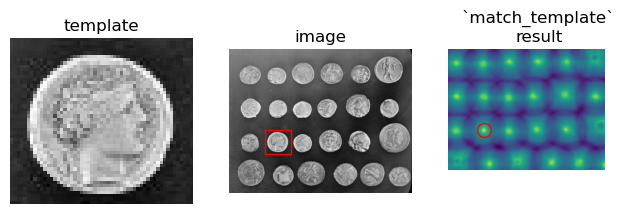

In [16]:
run_task5_pipeline()